In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms

In [28]:
# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [29]:
train_data = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=2)

test_data = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [30]:
# Define the teacher network
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(nn.functional.relu(self.conv4(x)))
        x = nn.functional.relu(self.conv5(x))
        x = self.pool(nn.functional.relu(self.conv6(x)))
        x = nn.functional.relu(self.conv7(x))
        x = self.pool(nn.functional.relu(self.conv8(x)))
        #print('x shape before ', x.shape)
        x = x.view(-1, 1024 * 2 * 2)
        #print('x shape after', x.shape)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
#model = TeacherNet()
#input_tensor = torch.randn(256, 3, 32, 32)
#output = model.forward(input_tensor)

In [45]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        #print('x shape before ', x.shape)
        x = x.view(-1, 16 * 16 * 16) 
        #print('x shape after ', x.shape)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#model = StudentNet()
#input_tensor = torch.randn(256, 3, 32, 32)
#output = model.forward(input_tensor)
#print(output.shape)

In [32]:
# Set device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [33]:
# Define the xavier_weight() function
def xavier_weight():
    def init_weight(weight):
        if isinstance(weight, nn.Conv2d):
            nn.init.xavier_uniform_(weight.weight)
        elif isinstance(weight, nn.Linear):
            nn.init.xavier_uniform_(weight.weight)
    return init_weight

In [34]:
# Initialize teacher network
teacher_net = TeacherNet().to(device)
teacher_net.apply(xavier_weight())

TeacherNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [46]:
# Initialize student network
student_net = StudentNet().to(device)
student_net.apply(xavier_weight())

StudentNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.Adam(teacher_net.parameters(), lr=0.001)
student_optimizer = optim.Adam(student_net.parameters(), lr=0.001)

In [54]:
#Train the teacher network

teacher_losses = []

def train_teacher():
    teacher_net.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Check batch sizes
        #print('Input tensor batch size:', data.size(0))
        #print('Target tensor batch size:', target.size(0))

        teacher_optimizer.zero_grad()
        output = teacher_net(data)
        
        #print("input size: ",data.shape)
        #print("target size: ", target.shape)
        #print('output size: ', output.shape)
        
        loss = criterion(output, target)
        loss.backward()
        teacher_optimizer.step()
        running_loss += loss.item()
        teacher_losses.append(running_loss/len(train_loader))
    print('Train Teacher Network: Epoch {} \t Loss: {:.6f}'.format(epoch, running_loss/len(train_loader)))

In [55]:
num_epochs = 10
for epoch in range (10):
    train_teacher()

Train Teacher Network: Epoch 0 	 Loss: 0.057677
Train Teacher Network: Epoch 1 	 Loss: 0.044536
Train Teacher Network: Epoch 2 	 Loss: 0.037981
Train Teacher Network: Epoch 3 	 Loss: 0.031428


KeyboardInterrupt: ignored

In [76]:
#Train the student network with knowledge distillation

student_losses = []

def train_student():
    teacher_net.eval()
    student_net.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        teacher_output = teacher_net(data)
        student_optimizer.zero_grad()
        student_output = student_net(data)
        loss = nn.functional.kl_div(nn.functional.log_softmax(student_output / 2.0, dim=1),
        nn.functional.softmax(teacher_output / 2.0, dim=1),
        reduction='batchmean') * 2.0 * 2.0
        loss.backward()
        student_optimizer.step()
        running_loss += loss.item()
        student_losses.append(running_loss/len(train_loader))
    print('Train Student Network: Epoch {} \t Loss: {:.6f}'.format(epoch, running_loss/len(train_loader)))

In [50]:
#Test the student network
def test_student():
    teacher_net.eval()
    student_net.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            teacher_output = teacher_net(data)
            output = student_net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
            accuracy = 100.0 * correct / len(test_loader.dataset)
    print('Test Student Network: Test Loss: {:.6f}, Accuracy: {:.2f}%'.format(test_loss, accuracy))


In [53]:
#Train the student network with knowledge distillation for 15 epochs
for epoch in range(1,16):
    train_student()
    test_student()

Student Network: Epoch 1 	 Loss: 1.180264
Student Network: Test Loss: 0.000017, Accuracy: 84.79%
Student Network: Epoch 2 	 Loss: 1.051913
Student Network: Test Loss: 0.000015, Accuracy: 86.06%
Student Network: Epoch 3 	 Loss: 0.939397
Student Network: Test Loss: 0.000015, Accuracy: 86.33%
Student Network: Epoch 4 	 Loss: 0.847877
Student Network: Test Loss: 0.000013, Accuracy: 87.19%
Student Network: Epoch 5 	 Loss: 0.771190
Student Network: Test Loss: 0.000014, Accuracy: 87.14%
Student Network: Epoch 6 	 Loss: 0.702909
Student Network: Test Loss: 0.000016, Accuracy: 87.48%
Student Network: Epoch 7 	 Loss: 0.649012
Student Network: Test Loss: 0.000014, Accuracy: 87.55%
Student Network: Epoch 8 	 Loss: 0.604804
Student Network: Test Loss: 0.000013, Accuracy: 88.16%
Student Network: Epoch 9 	 Loss: 0.564236
Student Network: Test Loss: 0.000013, Accuracy: 88.46%
Student Network: Epoch 10 	 Loss: 0.530408
Student Network: Test Loss: 0.000013, Accuracy: 88.28%
Student Network: Epoch 11 	 L

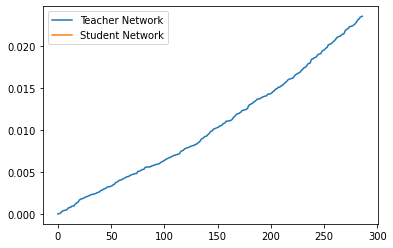

In [77]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(teacher_losses, label="Teacher Network")
plt.plot(student_losses, label="Student Network")
plt.legend()
plt.show()